In [15]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)
# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline
# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize
# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)
# Imputing missing values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer as Imputer
# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
# To load saved model
import pickle

In [2]:
# Read in data into dataframes 
train_features = pd.read_csv('training_features.csv')
test_features = pd.read_csv('testing_features.csv')
train_labels = pd.read_csv('training_labels.csv')
test_labels = pd.read_csv('testing_labels.csv')

In [3]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [7]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [8]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
#  Make predictions on the test set
model_pred = model.predict(X_test)
print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 9.0839


In [10]:
# Feature importance using SkLearn
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})
# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)
feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.452163
1,Weather Normalized Site Electricity Intensity ...,0.249107
2,Water Intensity (All Water Sources) (gal/ft²),0.056662
3,Property Id,0.031396
4,Largest Property Use Type_Non-Refrigerated War...,0.025153
5,DOF Gross Floor Area,0.025003
6,log_Water Intensity (All Water Sources) (gal/ft²),0.022335
7,Largest Property Use Type_Multifamily Housing,0.021462
8,Order,0.020169
9,log_Direct GHG Emissions (Metric Tons CO2e),0.019410


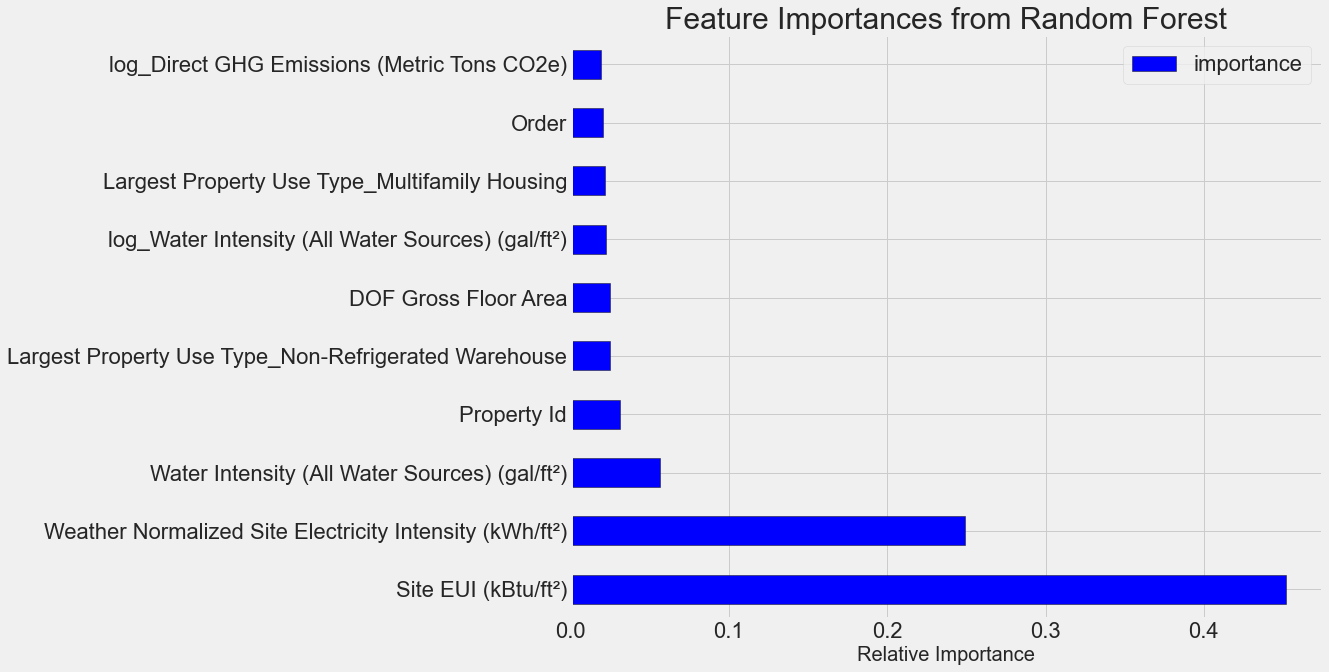

In [11]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

In [12]:
most_important_features = feature_results['feature'][:10]

# Finding the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keeping only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (6622, 10)
Most important testing  features shape:  (2839, 10)


In [13]:
lr = LinearRegression()
# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    13.4651.
Linear Regression Reduced Results: MAE = 14.5095.


In [14]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 9.3735
